# Sragvi Tirumala
## 2 May, 2018
## Intro to Data Science
## Rash Classification

This code is intended to extract texture related features from skin rash images. These features will be fed into a supervised classification binary tree/random forest framework. This method will then be fed into an ensemble learning method with the results from color classifiers as well as a Convolutional Neural Net.

In [323]:
%matplotlib inline
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage
from skimage import color

from skimage.feature import greycomatrix, greycoprops
from skimage.color import rgb2gray
from scipy.misc import imread
import pandas as pd

import os, glob

# TRAIN TEST SPLIT

In [324]:
#Standardized train test split across all learning methods
Xtraincsv = pd.read_csv(r'C:\Users\Asus\Documents\Grad School\Intro to Data Science\Project\traintestsets\Xtrain_data.csv')
ytraincsv = pd.read_csv(r'C:\Users\Asus\Documents\Grad School\Intro to Data Science\Project\traintestsets\ytrain.csv')
Xtestcsv = pd.read_csv(r'C:\Users\Asus\Documents\Grad School\Intro to Data Science\Project\traintestsets\Xtest_data.csv')
ytestcsv = pd.read_csv(r'C:\Users\Asus\Documents\Grad School\Intro to Data Science\Project\traintestsets\ytest.csv')

base_dir = r'C:\Users\Asus\Documents\Grad School\Intro to Data Science\Project\NewFinalImages'
Xtrain_feat = []
Xtest_feat = []
Xtrain_list=[]
Xtest_list=[]

traindis = []
testdis = []

for i in range(0,len(Xtraincsv)):
    disease = Xtraincsv.loc[i][2].split('\\')[-2]
    traindis.append(disease)
    filename = Xtraincsv.loc[i][2].split('\\')[-1]
    fullpath = os.path.join(base_dir,disease,filename)
    Xtrain_list.append(fullpath)
    im_temp = mpimg.imread(Xtrain_list[i])
    Xtrain_feat.append(im_temp) 
    

for i in range(0,len(Xtestcsv)):
    disease = Xtestcsv.loc[i][2].split('\\')[-2]
    testdis.append(disease)
    filename = Xtestcsv.loc[i][2].split('\\')[-1]
    fullpath = os.path.join(base_dir,disease,filename)
    Xtest_list.append(fullpath) 
    im_temp = mpimg.imread(Xtest_list[i])
    Xtest_feat.append(im_temp)   

# GLCM STATISTICS

In [400]:
#Store Gray-level co-occurrence matrix stats

TexStatsTrain = pd.DataFrame()
    
for img in Xtrain_feat:

    img2 = np.uint8(rgb2gray(img)*255)

    #compute gray-level co-occurrence matrix
    glcm = greycomatrix(img2, [1,5,10], [0,45,90], 256, symmetric=True)

    #ignore 0,0 adjacencies
    glcm[0,0,:,:] = 0
    
    contrast = (greycoprops(glcm, 'contrast')[0, 0])
    energy = (greycoprops(glcm, 'energy')[0, 0])
    TexStatsTrain = TexStatsTrain.append({'Contrast': contrast, 'Energy': energy},ignore_index = True)
    

#Same thing for test features

TexStatsTest = pd.DataFrame()
    
for img in Xtest_feat:

    img2 = np.uint8(rgb2gray(img)*255)

    #compute gray-level co-occurrence matrix
    glcm2 = greycomatrix(img2, [1,5,10], [0,45,90], 256, symmetric=True)

    #ignore 0,0 adjacencies
    glcm2[0,0,:,:] = 0

    contrast2 = (greycoprops(glcm2, 'contrast')[0, 0])
    energy2 = (greycoprops(glcm2, 'energy')[0, 0])
    TexStatsTest = TexStatsTest.append({'Contrast': contrast2, 'Energy': energy2},ignore_index = True)
    

C:\Users\Asus\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


# COLOR STATISTICS

In [449]:
# Find the threshold value and mean value of the red parts of the image, we assume some diseases are more red than others
from skimage.filters import threshold_mean

# store vals
redmean = []
redthresh = []

for img in Xtrain_feat:

    rimg = img[:,:,0]
    rnz = rimg[np.nonzero(rimg)]
    if (rnz.any()):
#         rnz = np.divide(rnz-np.min(rnz),(np.max(rnz) - np.min(rnz)))
        rm = np.mean(rnz)
        rt = threshold_mean(rnz)
        redmean.append(rm)
        redthresh.append(rt)
        
    else:
        redmean.append(0)
        redthresh.append(0)

TexStatsTrain['Redmean'] = redmean
TexStatsTrain['Redthresh'] = redthresh
    
    
#Same thing for test features
redmean2 = []
redthresh2 = []
    
for img in Xtest_feat:
    
    rimg = img[:,:,0]
    rnz = rimg[np.nonzero(rimg)]
    if (rnz.any()):
#         rnz = np.divide(rnz-np.min(rnz),(np.max(rnz) - np.min(rnz)))
        rm = np.mean(rnz)
        rt = threshold_mean(rnz)
        redmean2.append(rm)
        redthresh2.append(rt)
        
    else:
        redmean2.append(0)
        redthresh2.append(0)
        
        
TexStatsTest['Redmean'] = redmean2
TexStatsTest['Redthresh'] = redthresh2

TexStatsTrain['Label'] = traindis
TexStatsTest['Label'] = testdis

# DATAFRAME MANIPULATION

In [450]:
d = {'ATO': 1, 'contact': 2, 'MEL':3 , 'mim':4, 'PIT':5, 'PSO':6, 'RIN':7 }

TexStatsTrain['Label'] = TexStatsTrain['Label'].map(d)
TexStatsTest['Label'] =  TexStatsTest['Label'].map(d)

In [451]:
TexStatsTrain.head()

,Contrast,Energy,Redmean,Redthresh,Label
0,11287012.0,856.086444,132.890949,132.890949,5
1,12957538.0,1437.257110,162.844425,162.844425,5
2,3319102.0,240.595096,99.081754,99.081754,3
3,19906742.0,3017.674270,142.133749,142.133749,5
4,8396260.0,1688.839246,122.873777,122.873777,5


In [452]:
TexStatsTest.head()

,Contrast,Energy,Redmean,Redthresh,Label
0,10953918.0,1559.189533,167.285382,167.285382,7
1,9580508.0,1343.872762,151.952701,151.952701,7
2,2209580.0,3899.966154,126.504711,126.504711,5
3,9618552.0,674.437543,139.175840,139.175840,1
4,10492308.0,969.125379,91.116097,91.116097,7


# DECISION TREE CLASSIFIER

In [472]:
from sklearn import tree

#extract just x values
# features = list(TexStatsTrain.columns[:8])
features = list(TexStatsTrain.columns[:4])

#split into dependent and independent variables
y = TexStatsTrain["Label"]
X = TexStatsTrain[features]
ytest = TexStatsTest["Label"]
Xtest = TexStatsTest[features]
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X,y)



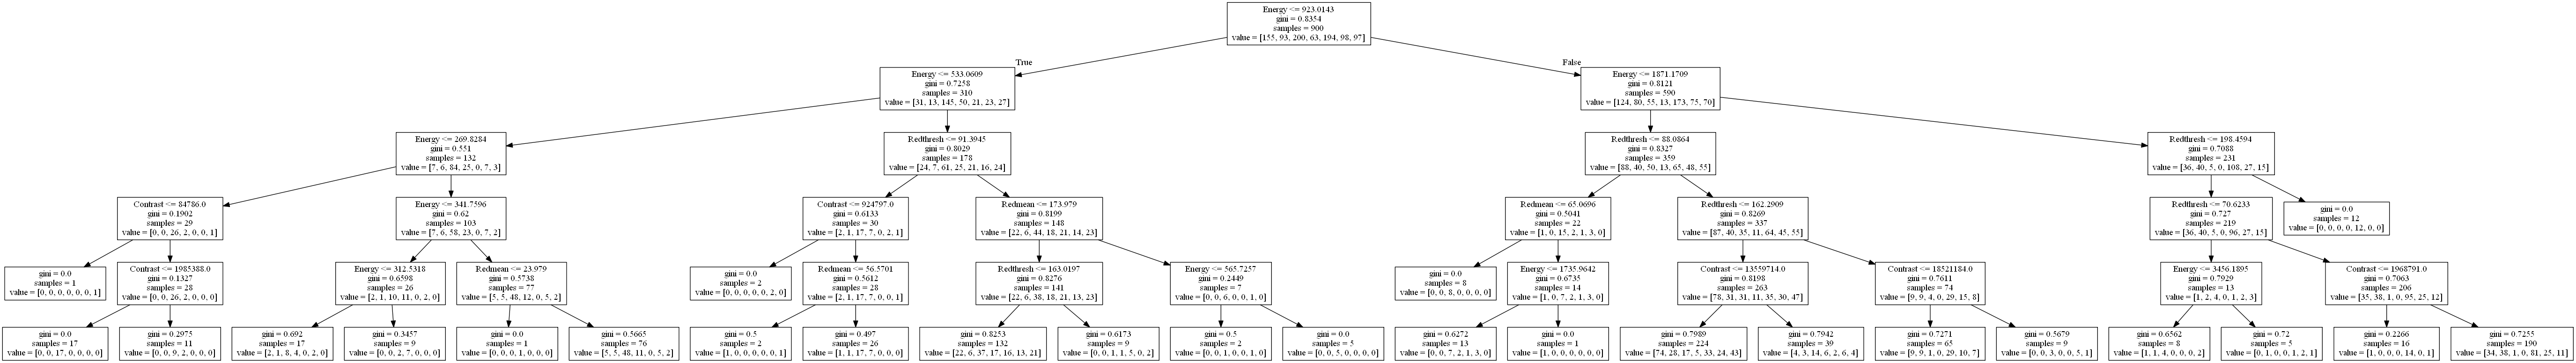

In [473]:
# decision tree
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [474]:
#random forest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, y)

In [475]:
TexStatsTrain['Label'].value_counts()

3    200
5    194
1    155
6     98
7     97
2     93
4     63
Name: Label, dtype: int64

# EVALUATING DECISION TREE CLASSIFIER

In [476]:
from sklearn import metrics

def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(X,y,clf, show_classification_report=False, show_confusion_matrix=False)



Accuracy:0.977 



In [477]:
# cross validation
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X, y, cv=10)

array([0.32, 0.34, 0.39, 0.41, 0.23, 0.28, 0.3 , 0.33, 0.33, 0.33])

In [478]:
from sklearn.metrics import confusion_matrix

y_pred=clf.predict(X)
confusion_matrix(y, y_pred)

array([[150,   0,   1,   0,   3,   0,   1],
       [  0,  92,   0,   0,   1,   0,   0],
       [  0,   0, 200,   0,   0,   0,   0],
       [  0,   1,   8,  53,   0,   0,   1],
       [  0,   1,   0,   0, 193,   0,   0],
       [  0,   0,   2,   0,   2,  94,   0],
       [  0,   0,   0,   0,   0,   0,  97]])

Confusion matrix, without normalization
[[150   0   1   0   3   0   1]
 [  0  92   0   0   1   0   0]
 [  0   0 200   0   0   0   0]
 [  0   1   8  53   0   0   1]
 [  0   1   0   0 193   0   0]
 [  0   0   2   0   2  94   0]
 [  0   0   0   0   0   0  97]]
Normalized confusion matrix
[[0.97 0.   0.01 0.   0.02 0.   0.01]
 [0.   0.99 0.   0.   0.01 0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.02 0.13 0.84 0.   0.   0.02]
 [0.   0.01 0.   0.   0.99 0.   0.  ]
 [0.   0.   0.02 0.   0.02 0.96 0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


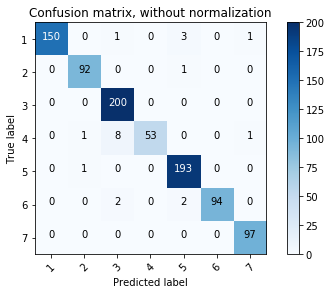

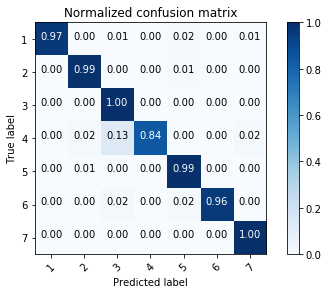

In [479]:
y_pred = clf.predict(X)
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# y_pred = model2.predict_classes(np.array(Xtrain_feat))
class_names = np.array(['1','2','3','4','5','6','7'])
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

# EVALUATE CLASSIFIER ON TESTING DATA

Accuracy:0.389 

Confusion matrix
[[15  6  6  1  6  1  6]
 [ 6  3  3  0  7  1  3]
 [ 2  4 43  4  4  3  1]
 [ 2  0  6  1  3  1  2]
 [ 9  7  4  0 18  2  3]
 [ 6  3  6  0  2  2  1]
 [ 2  2  5  0  8  0  6]] 

Confusion matrix, without normalization
[[15  6  6  1  6  1  6]
 [ 6  3  3  0  7  1  3]
 [ 2  4 43  4  4  3  1]
 [ 2  0  6  1  3  1  2]
 [ 9  7  4  0 18  2  3]
 [ 6  3  6  0  2  2  1]
 [ 2  2  5  0  8  0  6]]
Normalized confusion matrix
[[0.37 0.15 0.15 0.02 0.15 0.02 0.15]
 [0.26 0.13 0.13 0.   0.3  0.04 0.13]
 [0.03 0.07 0.7  0.07 0.07 0.05 0.02]
 [0.13 0.   0.4  0.07 0.2  0.07 0.13]
 [0.21 0.16 0.09 0.   0.42 0.05 0.07]
 [0.3  0.15 0.3  0.   0.1  0.1  0.05]
 [0.09 0.09 0.22 0.   0.35 0.   0.26]]


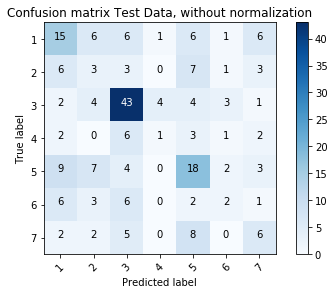

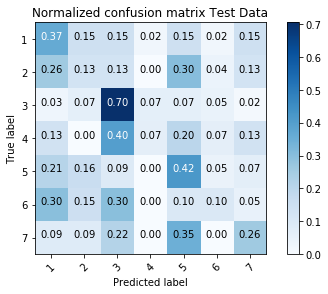

In [480]:
#Testing Data
y_pred_test=clf.predict(Xtest)  


measure_performance(Xtest,ytest,clf, show_classification_report=False, show_confusion_matrix=True)

cross_val_score(clf, Xtest, ytest, cv=10)

# confusion_matrix(ytest, y_pred_test)

class_names = np.array(['1','2','3','4','5','6','7'])
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, y_pred_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix Test Data, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix Test Data')

plt.show()

# OUTPUT RANDOM FORESTSCORES

In [488]:
# Training Data
myscores = clf.predict_proba(X)
mytestscores = clf.predict_proba(Xtest)
print(myscores[1,:])
np.shape(myscores)

np.save('RandomForestScores.npy', myscores)
np.save('RandomForestTestScores.npy', mytestscores)

[0. 0. 0. 0. 1. 0. 0.]


In [483]:
import pickle

# Dump the trained decision tree classifier with Pickle
decision_tree_pkl_filename = 'decision_tree_classifier.pkl'
# Open the file to save as pkl file
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(clf, decision_tree_model_pkl)
# Close the pickle instances
decision_tree_model_pkl.close()

# Loading the saved decision tree model pickle
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'rb')
decision_tree_model = pickle.load(decision_tree_model_pkl)
print ("Loaded Decision tree model :: ", decision_tree_model)

blahblah = decision_tree_model.predict(Xtest)

# FOR TESTING PURPOSES

In [489]:
#random forest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, y)


In [485]:

# Loading the saved decision tree model pickle
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'rb')
decision_tree_model = pickle.load(decision_tree_model_pkl)
print ("Loaded Decision tree model :: ", decision_tree_model)

blahblah = decision_tree_model.predict(Xtest)



Loaded Decision tree model ::  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [486]:
measure_performance(Xtest,ytest,decision_tree_model, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.389 

